# Table of content<a id='toc'></a>

0) [Abstract](#abstract)
1) [Image preprocessing](#preprocessing):
    - [Converting data from DCM files to PNG images.](#convert)
    - Windowing.
    - [Cropping out region of interest (RoI).](#roi)
    - [Resize images.](#resize)
2) [Preparing data for use in Torch](#data_preparation):
    - [Train test split.](#train_test_split)
    - [Data augmentation](#augmentation)
    - [Divide images by class.](#class_separation)
4) [Uploading data to cloud storage.](#upload)
5) [Torch preparation block](#torch):
    - Writing train and test loops.
    - Writing custom metric functions.
    - Creating datasets.
    - Implement transfer learning.
6) [Train model](#train).
7) Inference.
8) Conclusion.

# Abstract<a id='abstract'></a>

This notebook is based on RSNA Screening Mammography Breast Cancer Detection competition from Kaggle. My interest in data science and machine learning was initially sparked by medical applications, so I am excited to work on a project related to this field. The specific dataset I will be using comes from the aforementioned Kaggle competition. However, I will not be using the metric employed in the competition as my aim is not to participate but rather to address a problem of interest. Unlike the competition participants, I will focus on predicting the presence of cancer rather than its probability. It will be a binary classification problem with recall as the primary metric, though precision and F1 score will also be included as auxiliary metrics.

There is a CSV file containing patient data; however, I will not use it for making predictions this time. Instead, I aim to see if I can achieve acceptable results using only computer vision, despite the valuable information available. For instance, a brief exploratory data analysis (EDA) of the CSV file revealed that cancer is more common in older patients. Nevertheless, we want our model to make unbiased predictions based on tissue images alone and not consider age if some images have similar formations.


## Preprocessing<a id='preprocessing'></a>

In [1]:
%matplotlib inline
import os
import re
import glob
import shutil
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A #data augmentation
import pydicom # working with dcm files
import dicomsdl as dicoml
import cv2

Obtain a list of all DCM files and specify a directory to save PNG files to.

In [2]:
path_dicom = '../train_images/'
path_png = '../png/'
images_dicom = glob.glob(path_dicom+ '*/*.dcm')

Sequence of image transformation will appear as follows.

<img src='images/workflow.png'>

### Convert DCM to grayscale PNG and apply windowing.<a id='convert'></a>
[back to table of content](#toc)

DCM files are not merely images; they contain extensive metadata and look like this:

In [3]:
pydicom.dcmread('../train_images/5/640805896.dcm')

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.5.1.640805896
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.5.1.640805896
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184950.680341'
(0010, 0020) Patient ID                          LO: '5'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.5
(0020, 000e) Series Instance UID              

We are focused on the Center and Width parameters, which are essential for windowing. Incorrect values can corrupt images rather than enhance them. This issue occurred with half of the patients examined on a machine with ID 21. It took me quite a while but o found that this error was caused by the incorrect decoding of pixel data stored in a DCM file. Each pixel is stored in a bit representation, and pydicom decodes it using uint8 instead of float32, causing errors during windowing. For example, pydicom returned a pixel array with a maximum value of 164, while dicomsdl returned an array with a maximum value of 2600, which aligns well with the width and center parameters of the corresponding file. I had to skip corrupted images before, but now we have the benefit of windowing for all images.

For this reason, we will use dicomsdl instead of pydicom. It is also signficantly faster.

In [4]:
def convert_dcm_to_png_windowing(path_image: str, 
                                 dir_save_to: str='../png/cropped') -> None: # I save these images to "cropped" folder  right away
                                                                             # since we weill not need uncropped images in the future
    id_patient, id_img = re.findall('(\d+)', path_image)[-2:]
    path_save = os.path.join(dir_save_to, id_patient) 
    
    if os.path.isfile(os.path.join(path_save, id_img + '.png')):
        pass
    else:
            
        dicom = dicoml.open(path_image)
        
        img = dicom.pixelData()
        
        try:
            # Load only the variables we need
            center = dataset["WindowCenter"]
            width = dataset["WindowWidth"]
            bits_stored = dataset["BitsStored"]
            voi_lut_function = dataset["VOILUTFunction"]

            # For sigmoid it's a list, otherwise a single value
            if isinstance(center, list):
                center = center[0]
            if isinstance(width, list):
                width = width[0]
            # Code below is an adaptation of pydicom's apply_windowing().
            # It mostly repeats the original one.
            
            # Set y_min, max & range
            y_min = 0
            y_max = float(2**bits_stored - 1)
            y_range = y_max

            # VOI LUT parameter is no longer a common thing in dcm files, but we face it still sometimes. 
            # About 20% of our data has this Parameter set to SIGMOID
            if voi_lut_function == "SIGMOID":
                img = y_range / (1 + np.exp(-4 * (img - center) / width)) + y_min
            else:
                center -= 0.5
                width -= 1

                below = img <= (center - width / 2)
                above = img > (center + width / 2)
                between = np.logical_and(~below, ~above)

                img[below] = y_min
                img[above] = y_max
                if between.any():
                    img[between] = (
                        ((img[between] - center) / width + 0.5) * y_range + y_min
                    )
        except Exception as e:
            pass
    
        img = (img - img.min()) / (img.max() - img.min()) # to [0;1] scale
        
        if dicom.PhotometricInterpretation == 'MONOCHROME1':
            img = 1 - img
        
        img = (img * 255).astype(np.uint8)
        
        os.makedirs(path_save, exist_ok=True)
        cv2.imwrite(os.path.join(path_save, id_img + '.png') , img)  

In [5]:
# This one uses 1 core and goes for 15+ hours.
# for image in tqdm(images_dicom): 
#     convert_dcm_to_png_windowing(image, path_png)

Using multiprocessing to speed up the process.

In [6]:
from multiprocessing import Pool
with Pool(10) as p:
    list(tqdm(p.imap_unordered(convert_dcm_to_png_windowing, images_dicom), total=len(images_dicom)))

100%|███████████████████████████████████| 54706/54706 [1:30:47<00:00, 10.04it/s]


### RoI extraction<a id='roi'></a>
[back to table of content](#toc)

In most pictures, the largest part is a completely useless black background. To speed up training and save disk space, we will crop out only the useful part. We will use OpenCV for this task. The function `cv2.connectedComponentsWithStats` will provide us with a list of all connected regions of non-black pixels, and the largest one will contain our Region of Interest (RoI).

In [7]:
def crop_img(image: str, 
             dir_save_to: str='../png/cropped') -> None:
    
    X = cv2.imread(image)
    
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
    X = X[5:-5, 5:-5]
    
    # regions of non-empty pixels
    output= cv2.connectedComponentsWithStats((X > 20).astype(np.uint8)[:, :, 0], 8, cv2.CV_32S) # connectivity 4 insted of 8 may give us more regions which we don't want

    # output[0] is a number of labels
    # output[1] is matrix of labels
    # output[2] is stat matrix
    # output[4] is centroid matrix
    
    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]
    patient_id, id_img = re.findall('(\d+)', image)[-2:]

    try:
        # finding max area which always corresponds to the breast data. 
        idx = stats[1:, 4].argmax() + 1 # starting with 1 because largest region will be the whole picture
    except:
        return int(patient_id)
        
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    # cutting out the breast data
    X_roi = X[y1: y2, x1: x2]
    
    cv2.imwrite(f'{dir_save_to}/{patient_id}/{id_img}.png', X_roi[:, :, 0])


In [8]:
images_png = glob.glob(path_png+'*/*.png')
with Pool(10) as p:
    list(tqdm(p.imap_unordered(crop_img, images_png), total=len(images_png)))

100%|███████████████████████████████████| 54706/54706 [1:06:32<00:00, 13.70it/s]


### Resize<a id='resize'></a>
[back to table of content](#toc)

Setting height and width to 1280 and 720 respectively.

In [13]:
def resize_image(image: str, 
                 dir_save_to: str, 
                 size: tuple[int,int]=(720, 1280)) -> None:

    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, dsize=size)
    
    id_patient, id_img = re.findall('(\d+)', image)[-2:]
    os.makedirs(os.path.join(dir_save_to, id_patient), exist_ok=True)
    path_save = os.path.join(dir_save_to, id_patient, id_img+'.png')
    cv2.imwrite(path_save, img)

In [15]:
images_cropped = glob.glob(path_png+"cropped/*/*.png")
for image in tqdm(images_cropped):
    resize_image(image, path_png+"cropped_resized")

100%|█████████████████████████████████████| 54706/54706 [33:26<00:00, 27.26it/s]


## Preparing data for Torch <a id='data_preparation'></a>

### Train test split <a id='train_test_split'></a>
[back to table of content](#toc)

If we wanted, we could use this DataFrame to obtain auxiliary predictions, but some columns will not be available in the test DataFrame. I am uncertain whether we will use tabular data or if we will utilize columns exclusive to the training set. It would be ideal to try all three methods: using images only, making auxiliary predictions on tabular data excluding training-only columns, and making auxiliary predictions with training-only columns. However, hardware and time constraints currently limit me.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
df = pd.read_csv('train.csv')
#train_only_cols = ['density', 'biopsy', 'invasive', 'BIRADS', 'difficult_negative_case'] # for future potential use

Although we do not currently need this whole DataFrame, it would be beneficial to examine the data regardless.

In [18]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


Currently, we require only the image and patient IDs along with their respective target values.

In [19]:
y = df['cancer']
X = df.drop(columns=['cancer'])

This split will be applied only to images, not to patients; thus, images from a single patient folder may be assigned to different splits. I don't believe there is leakage: it is true that if a patient has cancer in one breast, the chances are higher for the other breast to be affected as well. However, we will not provide our ANN with information about which patient a particular image is assigned to.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [21]:
def split_images(X: pd.DataFrame, 
                 y: pd.Series, 
                 dir_source: str, 
                 dir_destination: str) -> None:
    
    '''This function is used to sort images to folders with name of respective class, so later we can use ImageFolder to create train and test datasets.
    Inputs:
        X: train or test dataset.
        y: train or test series of same length as X, containing target variables, i.e. "cancer" column of original DataFrame.
        dir_source: directory containing all folders with patient id.
        dir_destination: directory to move train or test data to, e.g. train_images_folder.
    Output: None
        Function will create "dir_destination/class/patient_id" path and move respective pictures there'''
    

    assert len(X) == len(y), "X and y must have same amount of elements. Check shapes of X and y."

    # Copy images from DataFrame to their class folders.
    for i in range(len(X)):
        
        id_patient = str(X.iloc[i]['patient_id'])
        id_image = str(X.iloc[i]['image_id']) + '.png'
        cancer = str(y.iloc[i])
    
        path_source = os.path.join(dir_source, id_patient, id_image)
        path_destination = os.path.join(dir_destination, cancer, id_patient)
        
        if os.path.isfile(path_source):
            os.makedirs(path_destination, exist_ok=True)
            shutil.copy(path_source, os.path.join(path_destination, id_image))
        else:
            continue

In [22]:
dir_source = '../png/cropped_resized' 
path_train_png = '../png/cropped_resized_split/train_images/' #train_images_png
path_test_png = '../png/cropped_resized_split/test_images/' #test_images_png

split_images(X_train, y_train, dir_source=dir_source, dir_destination=path_train_png)
split_images(X_test, y_test, dir_source=dir_source, dir_destination=path_test_png)

### Data Augmentation with Albumentations<a id='augmentation'></a>
[back to table of content](#toc)

I've been experimenting with various augmentation options and found that these make a fine mix of affine and pixel-wise transformations. These include rotating, flipping, and adjusting the brightness and contrast of images. Since the data is highly imbalanced, I will create multiple augmented copies of each positive class image to upsample it.

In [4]:
transform = A.Compose([
    A.SomeOf([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, border_mode=0,
                       value=0, mask_value=None, approximate=False, same_dxdy=False, p=0.5),
    ], n=2, replace=False, p=1),
    A.OneOf([
    A.PixelDropout (dropout_prob=0.15, per_channel=False, drop_value=0, mask_drop_value=None, p=0.5),
    A.RandomBrightnessContrast (brightness_limit=[-0.3,0.3], contrast_limit=[-0.2,0.2], brightness_by_max=True, p=0.5),
        ], p=0.6),
])


Take a look.

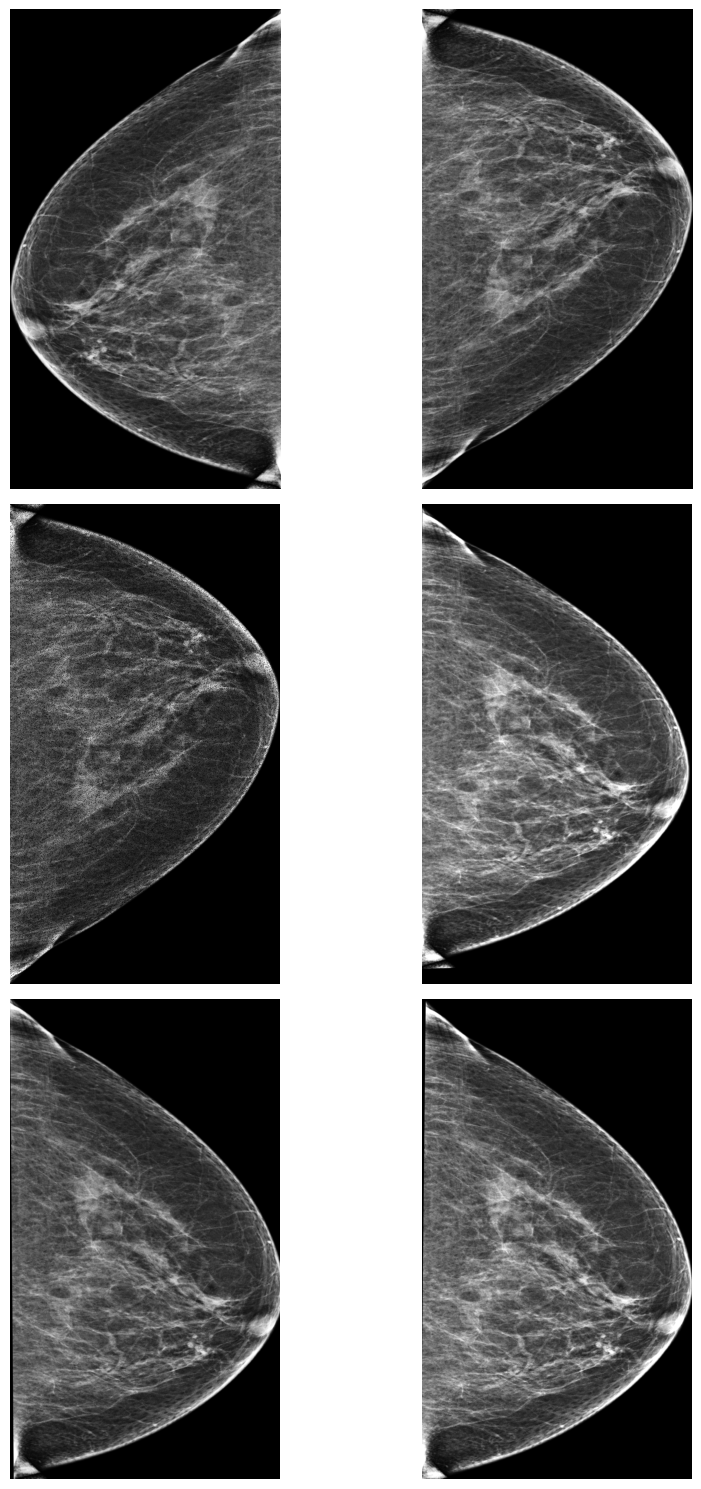

In [25]:
def show_augmentation(transform: A,
                      image: str) -> None:
    rows = 3
    cols = 2
    
    img_orig = Image.open(image)
    img_orig = np.array(img_orig)
    img_transformed = transform(image=img_orig)['image']

    fig = plt.figure(figsize=(10,15))
    fig.add_subplot(rows, cols, 1)
    plt.imshow(img_orig, cmap='gray')
    plt.axis(False)
    
    for i in range(2, cols* rows +1):
        fig.add_subplot(rows, cols, i)
        plt.imshow(transform(image=img_orig)['image'], cmap='gray')
        plt.axis(False)
    plt.tight_layout()
    
show_augmentation(transform, '../png/cropped_resized_split/train_images/0/1025/347069540.png')

We only augment train split.

In [5]:
def augment_images(image: str,
                   dir_dest: str) -> None:
        
    class_label, id_patient, id_img = re.findall('(\d+)',image)
        
    img_orig = Image.open(image)
    img_orig = np.array(img_orig)

    path_save = os.path.join(dir_dest, class_label, id_patient)
    os.makedirs(path_save, exist_ok=True)
    
    if int(class_label): #if cancer: make 3 augmented copies
        for i in range(3): 
            img_transformed = transform(image=img_orig)['image']
            cv2.imwrite(f'{path_save}/{id_img}_augmented_{i}.png', img_transformed)
    else:
        img_transformed = transform(image=img_orig)['image']
        cv2.imwrite(f'{path_save}/{id_img}_augmented_0.png', img_transformed)
            

In [6]:
train_images = glob.glob(path_train_png + '*/*/*.png')
for image in tqdm(train_images):
    augment_images(image, path_train_png)

100%|███████████████████████████████████| 43764/43764 [1:46:51<00:00,  6.83it/s]


## Divide images by class<a id='class_separation'></a>
[back to table of content](#toc)

In [7]:
def images_to_heap(dir_source: str,
                   dir_save: str) -> None:
    
    images = glob.glob(dir_source + '*/*/*.png')
    class_labels = set()
    for image in tqdm(images):
        
        class_label, id_patient= re.findall('(\d+)', image)[:2]
        class_labels.add(class_label)
        
        img_name = os.path.basename(image)
        file_name_new = f'{id_patient}_{img_name}'
        shutil.move(image, os.path.join(dir_save, class_label, file_name_new))
        
    #Remove empty folders
    for label in class_labels:        
        path_clean_up = f'{dir_source}/{label}'
        for folder in os.listdir(path_clean_up): 
            try:
                os.removedirs(os.path.join(path_clean_up, folder))
            except:
                pass

In [8]:
images_to_heap(path_train_png, path_train_png)

100%|██████████████████████████████████| 89380/89380 [00:02<00:00, 40977.07it/s]


In [9]:
images_to_heap(path_test_png, path_test_png)

100%|██████████████████████████████████| 10942/10942 [00:00<00:00, 34052.26it/s]


Now we have two folders: `train_images` and `test_images`<img src='images/folders.png'> , each containing two subfolders with images of classes respective to their folder names<img src='images/subfolders.png'>.

### Uploading data to Google Drive.<a id='upload'></a>
[back to table of content](#toc)

You may skip this part, as it is not crucial for the project's results. 

I created a web application in Google Workspace, obtained an authentication key, and tested whether I could view files on my Google Drive. The code used in the next cell is not mine; it is an example from Google API documentation.

In [ ]:
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload

# If modifying these scopes, delete the file token.json.
SCOPES = ["https://www.googleapis.com/auth/drive"]


def main():
  """
  Prints the names and ids of the first 10 files the user has access to.
  """
  creds = None
  # The file token.json stores the user's access and refresh tokens, and is
  # created automatically when the authorization flow completes for the first
  # time.
  if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json", SCOPES)
  # If there are no (valid) credentials available, let the user log in.
  if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
      creds.refresh(Request())
    else:
      flow = InstalledAppFlow.from_client_secrets_file(
          "credentials.json", SCOPES
      )
      creds = flow.run_local_server(port=8080)
    # Save the credentials for the next run
    with open("token.json", "w") as token:
      token.write(creds.to_json())

  try:
    service = build("drive", "v3", credentials=creds)

    # Call the Drive v3 API
    results = (
        service.files()
        .list(pageSize=10, fields="nextPageToken, files(id, name)")
        .execute()
    )
    items = results.get("files", [])

    if not items:
      print("No files found.")
      return
    print("Files:")
    for item in items:
      print(f"{item['name']} ({item['id']})")
  except HttpError as error:
    # TODO(developer) - Handle errors from drive API.
    print(f"An error occurred: {error}")

main()

I now upload files to my Google Drive, uploading the train and test folders separately. I've completed this process in another kernel, so I won't execute it here. The only result visible would be the progress bar anyway, but there is an example of code I ised to perform this step.

In [ ]:
service = build("drive", "v3", credentials=creds)
folder_id = '1hKB0SB5SPewBoYR3Lx7GSSLqjSej0vfW' # this is folder id on my Google Drive.
file_names = glob.glob('../png/train_images/1/*.png')
mime_type = 'image/png'

for file in tqdm(file_names): 
    file_metadata = {
        'name': os.path.basename(file),
        'parents': [folder_id],
    }
    
    media = MediaFileUpload(file, mime_type)

    service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id').execute()

## Torch block<a id='torch'></a>
[back to table of content](#toc)

In [9]:
# ML imports
import torch
import torchvision
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.datasets import ImageFolder
from torcheval.metrics.functional import binary_confusion_matrix 
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

* `precision`, `recall`, `accuracy`, `f_score`, `create_dataloader` and `freeze_model` are self-explanatory: those are custom metrics functions and functions for creating dataloaders and freezing hidden layers of a pretrained model.
* `train_step` may can be used as validation step if "validation" parameter is set to True. It returns step loss and binary confusion matrix that is later used for calculating metrics.
* `create_writer` creates SummaryWriter used by tensorboard. We will use the path to the writer for experiment tracking. Most likely, you will not see this, but I will use it a lot behind the scenes.
* `train_model` will perform train and validation steps for n epochs and return dictionary with metrics for each one. Although we will use TensorBoard and there is no need for this dictionary, I think it may be useful in my later projects if I won't use TensorBoard. This function will also print out some information about the training process so we won't be left wondering if it is working at all.

In [10]:
# metrics 

# tp = cm[1][1] 
# fp = cm[0][1] 
# fn = cm[1][0]
# tn = cm[0][0]

def precision(cm:np.ndarray) -> float:
    tp = cm[1][1] 
    fp = cm[0][1]
    if tp + fp == 0:
        return 0
    else:
        return tp / (tp + fp)

def recall(cm:np.ndarray) -> float:
    tp = cm[1][1] 
    fn = cm[1][0]
    if tp + fn == 0:
        return 0 
    else:
        return tp / (tp + fn)

def accuracy(cm:np.ndarray) -> float:
    tp = cm[1][1]
    tn = cm[0][0]
    return (tp + tn) / cm.sum()

def f_score(cm:np.ndarray, factor: int=1) -> float:
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
        
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
        
    if (precision == 0) and (recall == 0):
        f_score = 0
    else:
        f_score = (1 + factor ** 2) * ((precision * recall) / (factor * precision + recall))
        
    return f_score

# torch workflow
class custom_dataset(Dataset): # Deprecated. Saved for potential use in future projects.

    def __init__(self, class_folder, transform=None, n_samples=None):
        assert (n_samples is None) or (n_samples > 0), "Either specify desired positive non zero amount of samples or don't specify at all"

        super().__init__()
        self.class_folder = class_folder
        self.transform = transform
        self.n_samples = n_samples
        if self.n_samples:
            self.img_all = random.sample(glob.glob(self.class_folder+'/*.png'), self.n_samples)
        else:
            self.img_all = glob.glob(self.class_folder+'/*.png')

    def __len__(self):

        return len(self.img_all)

    def __getitem__(self, idx):

        path_img = self.img_all[idx]
        img = Image.open(path_img)

        if self.transform:
            img = self.transform(img)

        return (img, int(self.class_folder.split('/')[-1]))
        
def create_dataloader(dataset:str,
                      batch_size: int=16,
                      pin_memory: bool=True,
                      shuffle: bool=True) -> torch.utils.data.DataLoader:

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory
    )    
    
    return loader   

def train_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              optimizer: torch.optim.Optimizer,
              device: str,
              validation: bool=False) -> float:
    loss = 0
    if not validation:
        
        model.train()
        
        for X, y in dataloader:
            
            X, y = X.to(device), y.float().to(device)
    
            logits = model(X).squeeze()
            preds = logits.sigmoid().round()
    
            loss_batch = loss_fn(logits, y)
            loss += loss_batch.item()
            cm = binary_confusion_matrix(preds, y.long()).detach().cpu().numpy()
            
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        
    if validation:
        
        model.eval()
        with torch.inference_mode():

            for X, y in dataloader:
                
                X, y = X.to(device), y.float().to(device)
    
                logits = model(X).squeeze()
                preds = logits.sigmoid().round()
    
                loss_batch = loss_fn(logits, y)
                loss += loss_batch
                cm = binary_confusion_matrix(preds, y.long()).detach().cpu().numpy()

            
    return loss, cm

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.SummaryWriter():
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime('%Y-%m-%d')

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f'Created Summary Writer. Saved to {log_dir}.')

    return SummaryWriter(log_dir=log_dir)

def train_model(model: nn.Module,
                optimizer: torch.optim.Optimizer,
                loss_fn: nn.Module,
                loader_train: torch.utils.data.DataLoader,
                loader_test: torch.utils.data.DataLoader,
                writer: torch.utils.tensorboard.SummaryWriter(),
                device: str,
                n_epochs: int=11,
                ) -> dict:
  # Statistics to track.
    results = {'loss_train': [],
               'precision_train': [],
               'recall_train': [],
               'f_score_train': [],
               'loss_test': [],
               'precision_test': [],
               'recall_test': [],
               'f_score_test': [],
               }
    cm_train_total = 0
    cm_test_total = 0
    for epoch in range(n_epochs):

        print(f'Epoch #{epoch}')

        #train and test steps
        loss_train, cm_train = train_step(model, loader_train, loss_fn, optimizer, device)
        loss_test, cm_test = train_step(model, loader_test, loss_fn, optimizer, device, validation=True)
        cm_train_total += cm_train
        cm_test_total += cm_test
        # Update statistics in case we will need them later.
        results['loss_train'].append(loss_train)
        results['precision_train'].append(precision(cm_train))
        results['recall_train'].append(recall(cm_train))
        results['f_score_train'].append(f_score(cm_train))
        results['loss_test'].append(loss_test)
        results['precision_test'].append(precision(cm_test))
        results['recall_test'].append(recall(cm_test))
        results['f_score_test'].append(f_score(cm_test))
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'models/resnet18_{epoch}_epochs')
            print(f"Train loss: [{loss_train}] Train precision: [{results['precision_train'][-1]}]"\
                  f"Train recall: [{results['recall_train'][-1]}] Train F-score: [{results['f_score_train'][-1]}]\n"\
                  f"Test loss: [{loss_test}] Test precision[{results['precision_test'][-1]}] Test recall[{results['recall_test'][-1]}]"\
                  f"Test F-score: [{results['f_score_test'][-1]}]")
      
      # Update statistics for tensorboard.
    if writer:
        writer.add_scalars(main_tag='Loss',
                          tag_scalar_dict={'loss_train': loss_train,
                                            'loss_test': loss_test,},
                          global_step=epoch)
        
        writer.add_scalars(main_tag='Precision',
                          tag_scalar_dict={'precision_train': results['precision_train'][-1],
                                            'precision_test': results['precision_test'][-1]},
                          global_step=epoch)
        
        writer.add_scalars(main_tag='Recall',
                          tag_scalar_dict={'recall_train': results['recall_train'][-1],
                                        'recall_test': results['recall_test'][-1]},
                          global_step=epoch)
        
        writer.add_scalars(main_tag='F-score',
                          tag_scalar_dict={'f_score_train': results['f_score_train'][-1],
                                        'f_score_test': results['f_score_test'][-1]},
                          global_step=epoch)
        
        
    writer.close()
    return results, cm_train_total, cm_test_total

In [3]:
# Download model and weights
weights = ResNet101_Weights.DEFAULT
transforms_auto = weights.transforms()
transforms_auto

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Cropping is one of the preparation steps used by this model. However, since it has already been completed, we will proceed with our manual transformation.

In [ ]:
transforms_manual = Compose([
    Grayscale(),
    Resize(size=(232,232)), # Resize is redundant in Colab version of this Notebook sine all images on Google Drive are already 232x232.
    ToTensor(),
    Normalize(mean=[71.586], std=[52.692]), # These are mean and std of all images from our training set. 
])

In [ ]:
dataset_train = ImageFolder(path_train, transform=transforms_manual)
dataset_test = ImageFolder(path_test, transform=transforms_manual)

loader_train = create_dataloader(dataset_train)
loader_test = create_dataloader(dataset_test, shuffle=False)

In [11]:
# Model parameters.
model = resnet101(weights=weights)
freeze_model(model)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
model.to(device)

writer = create_writer('augmented',model.__class__.__name__, 'pretrained')
lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

Created Summary Writer. Saved to runs/2023-12-14/augmented/ResNet/pretrained.


In [12]:
summary(model=model, 
        input_size=(1, 1, 1024, 768),
)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 512, 384]         3,136
├─BatchNorm2d: 1-2                       [1, 64, 512, 384]         (128)
├─ReLU: 1-3                              [1, 64, 512, 384]         --
├─MaxPool2d: 1-4                         [1, 64, 256, 192]         --
├─Sequential: 1-5                        [1, 256, 256, 192]        --
│    └─Bottleneck: 2-1                   [1, 256, 256, 192]        --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 192]         (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 256, 192]         (128)
│    │    └─ReLU: 3-3                    [1, 64, 256, 192]         --
│    │    └─Conv2d: 3-4                  [1, 64, 256, 192]         (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 256, 192]         (128)
│    │    └─ReLU: 3-6                    [1, 64, 256, 192]    

### Deprecated: solution for Google Drive limitations.

Note: following part was made before deciding to use Resnet101 as a main model. I resized the images in the dataset to 232x232 and uploaded them to Google Drive. The whole resized dataset is now compatible with ImageFolder and can be used in Colab.

I cannot use the ImageFolder due to the large amount of data I have; Colab cannot read it all from Google Drive, and I am unable to use it all because of hardware limitations. Therefore, we must reduce the amount of data. I could not find a way to reduce the number of instances for only one class with ImageFolder, so I wrote a custom Dataset class that takes a random sample of N elements from a class folder. It looks cumbersome, but it is effective.

In [ ]:
# Data initialization.
path_train = '../train_images'
path_test = '../test_images'

dataset_train_1 = custom_dataset(os.path.join(path_train,'1'), transform=transforms_manual)
dataset_train_0 = custom_dataset(os.path.join(path_train,'0'), transform=transforms_manual, n_samples=len(dataset_train_1))
dataset_train = ConcatDataset([dataset_train_0,dataset_train_1])

dataset_test_1 = custom_dataset(os.path.join(path_test,'1'), transform=transforms_manual,)
dataset_test_0 = custom_dataset(os.path.join(path_test,'0'), transform=transforms_manual, n_samples=1000)
dataset_test = ConcatDataset([dataset_test_0,dataset_test_1])

loader_train = create_dataloader(dataset_train)
loader_test = create_dataloader(dataset_test, shuffle=False)

### Trainig model<a id='train'></a>

Hardware limitations significantly extend the duration of creating this block. Google Colab was inconsistent with the available hours of GPU usage, so I switched to Kaggle for training, which provides 30 hours per week. However, even with a lighter model such as ResNet18, it achieves less than 100 epochs. My experiments with ResNet18, ResNet50, ResNet101, and ConvNeXt Tiny led me to choose ResNet101 due to its lowest initial loss and marginally longer training time. Training on a dataset without augmentation revealed that all models exhibit 60% less loss on an augmented dataset from the start of training. I wish I could show you the results, but I don't know them myself yet. The loss is decreasing slowly but surely; it has decreased from an initial 650 to 450. This is a clean copy of a notebook, and I will add visuals here later. However, you can look at the work in progress on Kaggle: https://www.kaggle.com/code/mutasovdmitry/breast-test

I still use Colab for training but process is significantly slower. I resized all images to 232x232 and uploaded them to Drive so I could use full augmented dataset and `ImageFolder`. Learning may interrupt randomly at any given moment due to limits on using Colab's GPU, but it is better than nothing.

In [ ]:
results, cm_train, cm_test = train_model(model=model,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         loader_train=loader_train,
                                         loader_test=loader_test,
                                         device=device,
                                         writer=writer,
                                         n_epochs=1)